# Week 1 - Garbage Classification using EfficientNetV2B2

Improvements in this week:
- Image resized to 260x260 (EfficientNetV2B2 input size)
- Normalization and data augmentation
- Class weight handling for imbalanced dataset
- Model callbacks (EarlyStopping, ReduceLROnPlateau)

In [25]:
# Importing all the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Image resizing to 260x260 for EfficientNetV2B2

image_size = (260, 260)
batch_size = 32
seed = 42
dataset_dir = '/content/drive/MyDrive/Garbage_Classification_Dataset'

In [29]:
# splitting the training dataset from the images dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [30]:
# splitting the validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [31]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [32]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


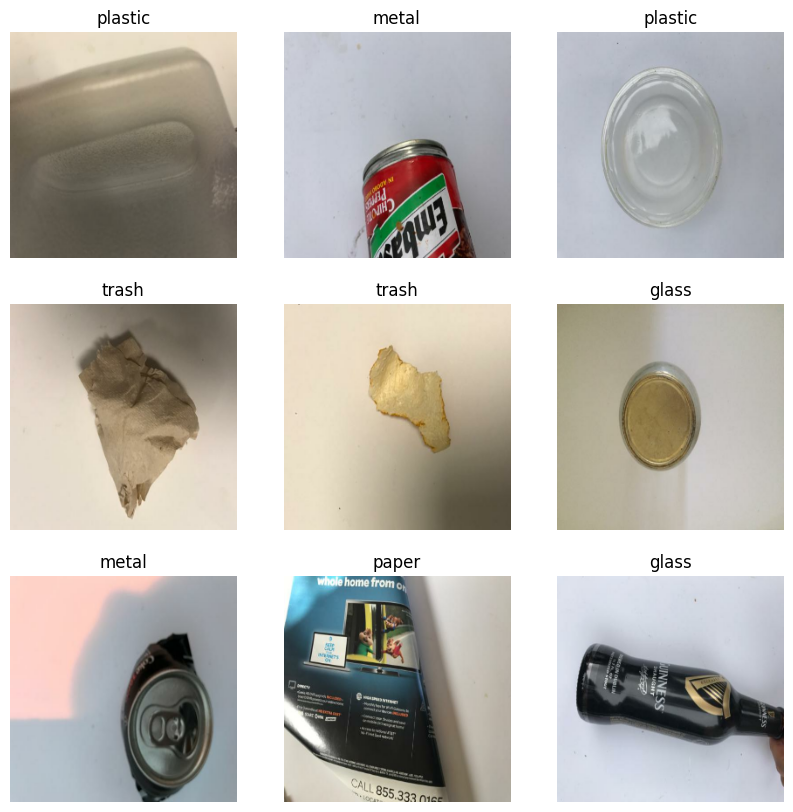

In [34]:
plt.figure(figsize=(10, 10))

# 9 random images from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

In [35]:
# Function to distribute percentages
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

In [36]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [37]:
class_names = train_ds.class_names

# Getting distributions for all the datasets
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}

for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


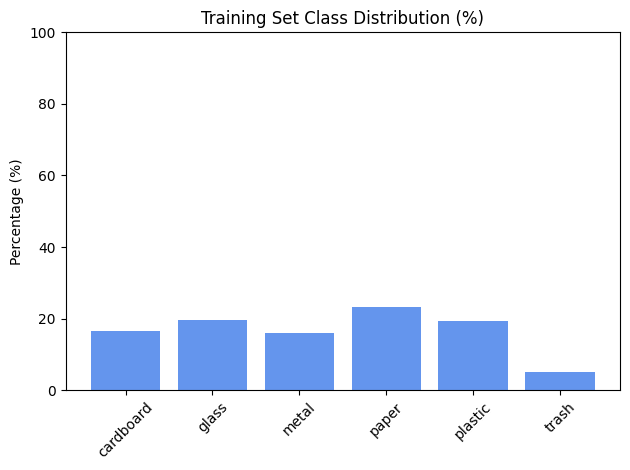

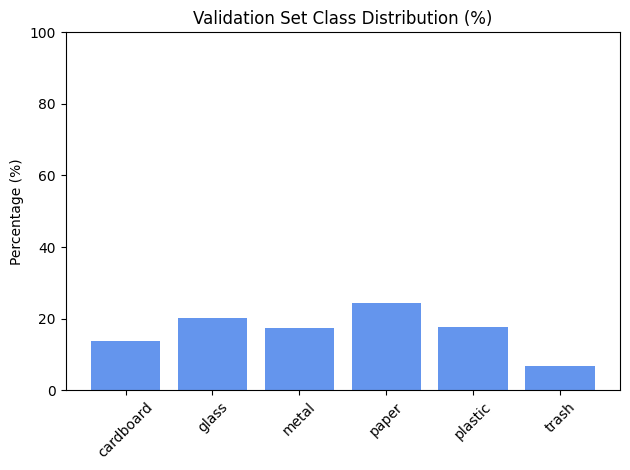

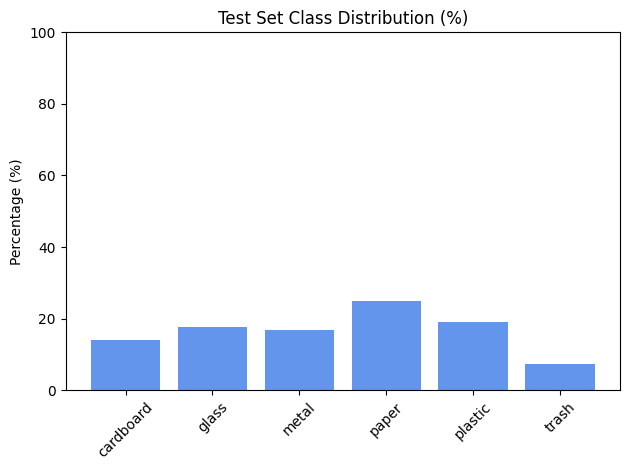

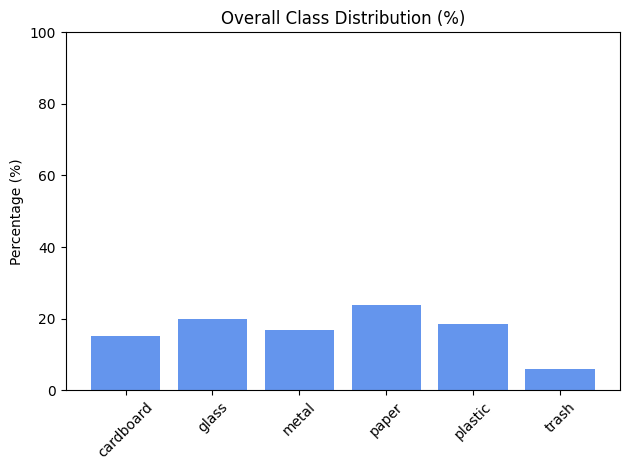

In [38]:
# Visualizations of all classes in the datasets
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [39]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [40]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [41]:
# Data pre processing
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [42]:
# Load the EfficientNetV2B2 model
base_model = EfficientNetV2B2(include_top=False, input_shape=(260, 260, 3), weights='imagenet', include_preprocessing=True)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


In [43]:
# Final model
model = Sequential([
    layers.Input(shape=(260, 260, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])



In [44]:
# Model compiling
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# Callbacks

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [46]:
# Training the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3887 - loss: 1.5782

64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 513ms/step - accuracy: 0.3907 - loss: 1.5755 - val_accuracy: 0.7347 - val_loss: 0.9349 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7530 - loss: 0.8368

64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.7534 - loss: 0.8355 - val_accuracy: 0.8634 - val_loss: 0.4922 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8519 - loss: 0.5076

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 407ms/step - accuracy: 0.8521 - loss: 0.5069 - val_accuracy: 0.9069 - val_loss: 0.3046 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9115 - loss: 0.3272

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - accuracy: 0.9113 - loss: 0.3273 - val_accuracy: 0.9168 - val_loss: 0.2597 - learning_rate: 1.0000e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9286 - loss: 0.2376

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.9285 - loss: 0.2376 - val_accuracy: 0.9228 - val_loss: 0.2202 - learning_rate: 1.0000e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9518 - loss: 0.1650

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9517 - loss: 0.1649 - val_accuracy: 0.9287 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 386ms/step - accuracy: 0.9547 - loss: 0.1395 - val_accuracy: 0.9168 - val_loss: 0.2481 - learning_rate: 1.0000e-04
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 375ms/step - accuracy: 0.9523 - loss: 0.1465 - val_accuracy: 0.9248 - val_loss: 0.2119 - learning_rate: 1.0000e-04
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9790 - loss: 0.0850

64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 408ms/step - accuracy: 0.9789 - loss: 0.0852 - val_accuracy: 0.9287 - val_loss: 0.1956 - learning_rate: 5.0000e-05
Epoch 10/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9766 - loss: 0.0737

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.9766 - loss: 0.0736 - val_accuracy: 0.9347 - val_loss: 0.1720 - learning_rate: 5.0000e-05
Epoch 11/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9790 - loss: 0.0743

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 395ms/step - accuracy: 0.9790 - loss: 0.0743 - val_accuracy: 0.9347 - val_loss: 0.1688 - learning_rate: 5.0000e-05
Epoch 12/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9848 - loss: 0.0560

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.9848 - loss: 0.0561 - val_accuracy: 0.9446 - val_loss: 0.1564 - learning_rate: 5.0000e-05
Epoch 13/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - accuracy: 0.9802 - loss: 0.0673 - val_accuracy: 0.9347 - val_loss: 0.1638 - learning_rate: 5.0000e-05
Epoch 14/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9792 - loss: 0.0585

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 410ms/step - accuracy: 0.9792 - loss: 0.0586 - val_accuracy: 0.9465 - val_loss: 0.1332 - learning_rate: 5.0000e-05
Epoch 15/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 39s 379ms/step - accuracy: 0.9931 - loss: 0.0397 - val_accuracy: 0.9406 - val_loss: 0.1434 - learning_rate: 5.0000e-05


In [47]:
# Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [48]:
# Print the architecture summary of the base model
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 260, 260,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)